# Homework 2

### Due Date: Friday, March 20

### Policy Gradient

In this assignment, we will implement vanilla policy gradient algorithm (REINFORCE) covered in the lecture. You will work on i) a function approximator, ii) computing action, iii) collecting samples, iV) training the agent, V) plotting the resutls. 


***Complete the missing operations and test your implemented algorithm on the Gym environment.***

***Software requirements:***
- Python >= 3.6
- Tensorflow version <= 1.15.3 (1.X version)
- OpenAI Gym

- Training the agent (policy) can take long time. It is recomended to start solving the problems earlier.

- Save any plots you generated in this notebook. The grade will be given based on the plots you showed.



Make sure the packages you installed meet the requirements.

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
import gym
gym.__version__

'0.18.0'

## 1.1 Tensorflow Implementation

We will be implementing policy gradient algorithm using Tensorflow 1.X., which simply updates the parameters of policy from obtaining gradient estimates. The core of policy gradient is to design a function approximator, computing actions, collecting samples, and training the policy. In the below cell, you are encouraged to fill in the components that are missing. ***Your tasks*** are 

1. Complete the 'create_model' method to output the mean value for diagonal Guassian policy. Covariance is already defined in the model, so focus on creating neural network model.

2. Complete the 'action_op' method to calculate and return the actions for diagonal Gaussian policy. The applied action should be $\pi(s) = \pi_{\text{mean}}(s) + exp(logstd) * \mathcal{N}(0,1)$

***Hints***:
- Some useful tensorflow classes and methods include: 'tf.exp', 'tf.random_normal'



***IF you are using MAC, please run below box***

In [3]:
#import os
# MAC user only
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
import tensorflow as tf
import numpy as np
import os
import ipdb


class PolicyOpt(object):

    def __init__(self, env, linear=False, stochastic=True, hidden_size=32, nonlinearity=tf.nn.relu):
        """Instantiate the policy iteration class.

        This initializes the policy optimization with a set of trainable 
        parameters, and creates a tensorflow session.

        Attributes
        ----------
        env : gym.Env
            the environment that the policy will be trained on
        linear : bool, optional
            specifies whether to use a linear or neural network 
            policy, defaults to False (i.e. Fully-Connected-Neural-Network)
        stochastic : bool, optional
            specifies whether to use a stochastic or deterministic 
            policy, defaults to True
        hidden_size : list of int, optional
            list of hidden layers, with each value corresponding 
            to the number of nodes in that layer 
        nonlinearity : tf.nn.*
            activation nonlinearity
        """
        
        # clear computation graph
        tf.reset_default_graph()
        
        # set a random seed
        tf.set_random_seed(1234)
        
        # start a tensorflow session
        self.sess = tf.Session()
        
        # environment to train on
        self.env = env
        
        # number of elements in the action space
        self.ac_dim = env.action_space.shape[0]
        
        # number of elements in the observation space
        self.obs_dim = env.observation_space.shape[0]

        # actions placeholder
        self.a_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.ac_dim])
        # state placeholder
        self.s_t_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None, self.obs_dim])
        # expected reward placeholder
        self.rew_ph = tf.placeholder(dtype=tf.float32, 
                                     shape=[None])

        # specifies whether the policy is stochastic
        self.stochastic = stochastic

        # policy that the agent executes during training/testing
        self.policy = self.create_model(
            args={
                "num_actions": self.ac_dim,
                "hidden_size": hidden_size,
                "linear": linear,
                "nonlinearity": nonlinearity,
                "stochastic": stochastic,
                "scope": "policy",
            }
        )
        
        # define symbolic action
        self.symbolic_action = self.action_op()

        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

        # create saver to save model variables
        self.saver = tf.train.Saver()

    def create_model(self, args):
        """Create a model for your policy or other components.

        Parameters
        ----------
        args : dict
            model-specific arguments, with keys:
              - "stochastic": True by default
              - "hidden_size": Number of neurons in hidden layer
              - "num_actions" number of output actions
              - "scope": scope of the model

        Returns
        -------
        tf.Variable
            mean actions of the policy
        tf.Variable 
            logstd of the policy actions
        """

#################### Build Your Neural Network Here! ####################   

        #number of neuron in layer
        hidden_size=args["hidden_size"]
        #number of outputs
        output_size=args["num_actions"]
        #for this algorithm we will use 2 neuron layers.
        layer_1=tf.layers.dense(self.s_t_ph,args["hidden_size"],activation=args["nonlinearity"])
        layer_2=tf.layers.dense(layer_1,args["hidden_size"],activation=tf.nn.relu)
        #layer_n=tf.layers.dense(layer_n-1,args["hidden_size"],activation=tf.nn.relu)
      
        #output layer
        output_mean=tf.layers.dense(layer_2,args["num_actions"])
        
##########################################################################        

        if args["stochastic"]:
            output_logstd =  tf.get_variable(name="action_logstd",shape=[self.ac_dim],trainable=True)
        else:
            output_logstd = None

        return output_mean, output_logstd
    
    def action_op(self):
        """
        Create a symbolic expression that will be used to compute actions from observations.

        When the policy is stochastic, the action follows 

            a_t = output_mean + exp(output_logstd) * z; z ~ N(0,1)
        """
        if self.stochastic:
            output_mean, output_logstd = self.policy

            #################### Implement a stochastic policy here ####################        
            # Implement a stochastic version of computing actions.       #
            #                                                            #
            # The action in a stochastic policy represented by           #
            # a diagonal Gaussian distribution with mean "M" and log     #
            # standard deviation "logstd" is computed as follows:        #
            #                                                            #
            #     a = M + exp(logstd) * z                                #
            #                                                            #
            # where z is a random normal value, i.e. z ~ N(0,1)          #
            #                                                            #
            # In order to generate numbers from a normal distribution,   #
            # use the `tf.random_normal` function.                       #
            ############################################################################ 
            symbolic_action = output_mean+tf.math.exp(output_logstd)*tf.random_normal([1])
            
        else:
            symbolic_action, _ = self.policy
        
        return symbolic_action

    def compute_action(self, obs):
        """Returns a list of actions for a given observation.

        Parameters
        ----------
        obs : np.ndarray
            observations

        Returns
        -------
        np.ndarray
            actions by the policy for a given observation
        """
        return self.sess.run(self.symbolic_action,feed_dict={self.s_t_ph: obs})

    def rollout(self, s_mean=None, s_std=None):
        """Collect samples from one rollout of the policy.

        Returns
        -------
        dict
            dictionary containing trajectory information for the rollout,
            specifically containing keys for "state", "action", "next_state", "reward", and "done"
        """
        states = []
        next_states = []
        actions = []
        rewards = []
        dones = []

        # start a new rollout by re-setting the environment and collecting the initial state
        state =  self.env.reset()

        steps = 0
        while True:
            steps += 1

            # compute the action given the state
            if s_mean is not None and s_std is not None:
                action = self.compute_action([(state - s_mean) / s_std])
            else:
                action = self.compute_action([state])
            action = action[0]

            # advance the environment once and collect the next state, reward, done, and info parameters from the environment
            next_state, reward, done, info =  self.env.step(action)

            # add to the samples list
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)

            state = next_state

            # if the environment returns a True for the done parameter,
            # end the rollout before the time horizon is met
            if done or steps > env._max_episode_steps:
                break

        # create the output trajectory
        trajectory = {"state": np.array(states, dtype=np.float32),
                      "reward": np.array(rewards, dtype=np.float32),
                      "action": np.array(actions, dtype=np.float32),
                      "next_state": np.array(next_states, dtype=np.float32),
                      "done": np.array(dones, dtype=np.float32)}

        return trajectory

    def train(self, args):
        """Abstract training method.

        This method will be filled in by algorithm-specific
        training operations in subsequent problems.

        Parameters
        ----------
        args : dict
            algorithm-specific hyperparameters
        """
        raise NotImplementedError



## 1.2 Tensorflow Interpretation

In order to test your implementation of the **stochastic policy**, run the below cell. The task is to interpret the code you implemented in previous section. If you implement correctly, you can see the value_1 and value_2.

***Question: How do you interpret value_1 and value_2 below cell?***


In [5]:
import gym
TEST_ENV = gym.make("Pendulum-v0")

alg = PolicyOpt(TEST_ENV, linear=False)
input_1 = [[0, 1, 2]]
value_1 = alg.sess.run(alg.policy[0], feed_dict={alg.s_t_ph: input_1})
value_2 = alg.compute_action(input_1)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [6]:
value_1


array([[0.18702136]], dtype=float32)

Answer:This is the average value of the weight of the layers

In [7]:
value_2

array([[-0.05820368]], dtype=float32)

Answer:This is variace of the actual weights

## 1.3 Implement Policy Gradient

In this section, we will implement REINFORCE algorithm presented in the lecture. As a review, the objective is optimize the parameters $\theta$ of some policy $\pi_\theta$ so that the expected return

\begin{equation}
J(\theta) = \mathbb{E} \bigg\{ \sum_{t=0}^T \gamma^t r(s_{t},a_{t}) \bigg\}
\end{equation}

is optimized. In this algorithm, this is done by calculating the gradient $\nabla_\theta J$ and applying a gradient descent method to find a better policy.

\begin{equation}
\theta ' = \theta + \alpha \nabla_\theta J(\theta)
\end{equation}

In the lecture, we derive how we compute $\nabla_{\theta} J(\theta)$. We can rewrite our policy gradient as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \bigg( \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \bigg) \bigg( \sum_{t=0}^T \gamma^{t}r_i(t) \bigg)
\end{equation}

Finally, taking into account the causality principle discussed in class, we are able to simplifiy the gradient estimate such as:

\begin{equation}
\nabla_\theta J (\theta) \approx \frac{1}{N} \sum_{i=0}^{N} \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta (a_{it} | s_{it}) \sum_{t'=t}^T \gamma^{t'-t}r_i(t')
\end{equation}

You will be implementing final expression in this assignment!



The process of REINFOCE algorithm follows:

1. Collect samples from current policy $\pi_\theta(s)$ by executing rollouts of the environment.
2. Calculate an estimate for the expected return at state $s_t$. 
3. Compute the log-likelihood of each action that was performed by the policy at every given step.
4. Estimate the gradient and update the parameters of policy using gradient-based technique.
5. Repeat steps 1-4 for a number of training iterations.

***Your task*** is to fill out the skeleton code for REINFORCE algorithm,

1. Complete the 'log_likelihoods' method to compute gradient of policy, $\nabla_{\theta}\pi_{\theta}$ for diagonal Guassian policy. 

2. Complete the 'compute_expected_return' method to calculate the reward-to-go, $\sum_{t^{\prime}=t}^{T}$. 



In [8]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp

class REINFORCE(PolicyOpt):

    def train(self, num_iterations=1000, steps_per_iteration=1000, learning_rate=int(1e-4), gamma=0.95, 
              **kwargs):
        """Perform the REINFORE training operation.

        Parameters
        ----------
        num_iterations : int
            number of training iterations
        steps_per_iteration : int
            number of individual samples collected every training iteration
        learning_rate : float
            optimizer learning rate
        gamma : float
            discount rate
        kwargs : dict
            additional arguments

        Returns
        -------
        list of float
            average return per iteration
        """
        # set the discount as an attribute
        self.gamma = gamma
        
        # set the learning rate as an attribute
        self.learning_rate = learning_rate

        # create a symbolic expression to compute the log-likelihoods 
        log_likelihoods = self.log_likelihoods()

        # create a symbolic expression for updating the parameters of your policy
        self.opt, self.opt_baseline = self.define_updates(log_likelihoods)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())


        # average return per training iteration
        ret_per_iteration = []
        
        samples = []
        for i in range(num_iterations):
            
            # collect samples from the current policy
            samples.clear()
            steps_so_far = 0
            while steps_so_far < steps_per_iteration:
                new_samples = self.rollout()
                steps_so_far += new_samples["action"].shape[0]
                samples.append(new_samples)

            # compute the expected returns
            v_s = self.compute_expected_return(samples)

            # compute and apply the gradients
            self.call_updates(log_likelihoods, samples, v_s, **kwargs)

            # compute the average cumulative return per iteration
            average_rew = np.mean([sum(s["reward"]) for s in samples])

            # display iteration statistics
            print("Iteration {} return: {}".format(i, average_rew))
            ret_per_iteration.append(average_rew)

        return ret_per_iteration

    def log_likelihoods(self):
        """Create a tensorflow operation that computes the log-likelihood 
        of each performed action.
        """
        
        output_mean, output_logstd = self.policy

        ##############################################################
        # Create a tf operation to compute the log-likelihood of     #
        # each action that was performed by the policy               #
        #                                                            #
        # The log likelihood in the continuous case where the policy #
        # is expressed by a multivariate gaussian can be computing   #
        # using the tensorflow object:                               #
        #                                                            #
        #    p = tfp.distributions.MultivariateNormalDiag(           #
        #        loc=...,                                            #
        #        scale_diag=...,                                     #
        #    )                                                       #
        #                                                            #
        # This method takes as input a mean (loc) and standard       #
        # deviation (scale_diag), and then can be used to compute    #
        # the log-likelihood of a variable as follows:               #
        #                                                            #
        #    log_likelihoods = p.log_prob(...)                       #
        #                                                            #
        # For this operation, you will want to use placeholders      #
        # created in the __init__ method of problem 1.               #
        ##############################################################

        p = tfp.distributions.MultivariateNormalDiag(loc=output_mean,scale_diag=output_logstd)
        log_likelihoods = p.log_prob(self.a_t_ph)

        return log_likelihoods

    def compute_expected_return(self, samples):
        """Compute the expected return from a given starting state.
        This is done by using the reward-to-go method.

        Parameters
        ----------
        rewards : list of list of float
            a list of N trajectories, with each trajectory contain T 
            returns values (one for each step in the trajectory)

        Returns
        -------
        list of float, or np.ndarray
            expected returns for each step in each trajectory
        """
        rewards = [s["reward"] for s in samples]

        ##############################################################
        # Estimate the expected return from any given starting state #
        # using the reward-to-go method.                             #
        #                                                            #
        # Using this method, the reward is estimated at every step   #
        # of the trajectory as follows:                              #
        #                                                            #
        #   r = sum_{t'=t}^T gamma^(t'-t) * r_{t'}                   #
        #                                                            #
        # where T is the time horizon at t is the index of the       #
        # current reward in the trajectory. For example, for a given #
        # set of rewards r = [1,1,1,1] and discount rate gamma = 1,  #
        # the expected reward-to-go would be:                        #
        #                                                            #
        #   v_s = [4, 3, 2, 1]                                       #
        #                                                            #
        # You will be able to test this in one of the cells below!   #
        ##############################################################
       
        v_s = []
        c = 0;
        for r in range(len(rewards)):
            for x in range(len(rewards[r])):
                v_s.append(0)
                for y in range(x,len(rewards[r])):
                    v_s[c] += (self.gamma**(y-x))*rewards[r][y]
                c +=1
                               
                                               
        return v_s

    def define_updates(self, log_likelihoods):
        """Create a tensorflow operation to update the parameters of 
        your policy.

        Parameters
        ----------
        log_likelihoods : tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions

        Returns
        -------
        tf.Operation
            a tensorflow operation for computing and applying the 
            gradients to the parameters of the policy
        None
            the second component is used in problem 2.b, please ignore 
            for this problem
        """

        loss = - tf.reduce_mean(tf.multiply(log_likelihoods, self.rew_ph))
        opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)

        return opt, None

    def call_updates(self, log_likelihoods, samples, v_s, **kwargs):
        """Apply the gradient update methods in a tensorflow session.

        Parameters
        ----------
        log_likelihoods: tf.Operation
            the symbolic expression you created to estimate the log 
            likelihood of a set of actions
        samples : list of dict
            a list of N trajectories, with each trajectory containing 
            a dictionary of trajectory data (see self.rollout)
        v_s : list of float, or np.ndarray
            the estimated expected returns from your
            `comput_expected_return` function 
        kwargs : dict
            additional arguments (used in question 3)
        """
        # concatenate the states
        states = np.concatenate([s["state"] for s in samples])

        # concatenate the actions
        actions = np.concatenate([s["action"] for s in samples])

        # execute the optimization step
        self.sess.run(self.opt, feed_dict={self.s_t_ph: states,
                                           self.a_t_ph: actions,
                                           self.rew_ph: v_s})

Check your 'log_likelihoods' method by running below cell:

In [9]:
alg = REINFORCE(TEST_ENV, stochastic=True)

log_likelihoods = alg.log_likelihoods()

# collect a sample output for a given input state
input_s = [[0, 0, 0], [0, 1, 2], [1, 2, 3]]
input_a = [[0], [1], [2]]

# Check
computed = alg.sess.run(log_likelihoods, feed_dict={alg.a_t_ph: input_a, alg.s_t_ph: input_s})

Test your 'compute_expected_return' by running below cell:

In [10]:
# 1. Test the non-normalized case
alg = REINFORCE(TEST_ENV, stochastic=True)
alg.gamma = 1.0
    
input_1 = [{"reward": [1, 1, 1, 1]},
           {"reward": [1, 1, 1, 1]}]
vs_1 = alg.compute_expected_return(samples=input_1)
ans_1 = np.array([4, 3, 2, 1, 4, 3, 2, 1])

if np.linalg.norm(vs_1 - ans_1) < 1e-3:
    print('Great job!')
else:
    print('Check your implementation (compute_expected_return)')

    

Great job!


## 1.4 Testing your algorithm

When you are ready, test your policy gradient algorithms on the *Pendulum-v0* environment in the cell below. *Pendulum-v0* environment is similar to *off-shore wind power*, the goal here is to maintain the Pendulum is upright using control input. The best policy should get around -200 scores. ***Your task*** is to run your REINFORCE algorithm and plot the result!


In [11]:
# set this number as 1 for testing your algorithm, and 3 for plotting
NUM_TRIALS = 3

# ===========================================================================
# Do not modify below line
# ===========================================================================

# we will test the algorithms on the Pendulum-v0 gym environment
import gym
env = gym.make("Pendulum-v0")

# train on the REINFORCE algorithm
import numpy as np
r = []
for i in range(NUM_TRIALS):
    print("\n==== Training Run {} ====".format(i))
    alg = REINFORCE(env, stochastic=True)
    res = alg.train(learning_rate=0.005, gamma=0.95, num_iterations=500, steps_per_iteration=15000)
    r.append(np.array(res))
    alg = None

# save results
np.savetxt("InvertedPendulum_results.csv", np.array(r), delimiter=",")


==== Training Run 0 ====
Iteration 0 return: -1206.014105910957
Iteration 1 return: -1181.5686430805736
Iteration 2 return: -1158.6372000681174
Iteration 3 return: -1146.8919754727267
Iteration 4 return: -1138.8995311080262
Iteration 5 return: -1118.5697155643502
Iteration 6 return: -1125.4307819649887
Iteration 7 return: -1152.7156229133998
Iteration 8 return: -1158.7352435821015
Iteration 9 return: -1126.0551668850674
Iteration 10 return: -1138.150490087384
Iteration 11 return: -1149.508095531258
Iteration 12 return: -1171.3581713129595
Iteration 13 return: -1199.9680039173115
Iteration 14 return: -1170.89077148218
Iteration 15 return: -1177.1998633542346
Iteration 16 return: -1209.1976926691318
Iteration 17 return: -1142.9414867070254
Iteration 18 return: -1107.9922462268314
Iteration 19 return: -1095.7723474705451
Iteration 20 return: -1075.1090725643933
Iteration 21 return: -1061.9158423310394
Iteration 22 return: -1064.6386301811815
Iteration 23 return: -1092.5589852117002
Itera

Iteration 200 return: -215.4915815939476
Iteration 201 return: -232.93443732358884
Iteration 202 return: -211.12042597508795
Iteration 203 return: -211.89113994426322
Iteration 204 return: -217.09252617321442
Iteration 205 return: -222.95698919557427
Iteration 206 return: -239.29736400130778
Iteration 207 return: -230.46772086084408
Iteration 208 return: -220.1733458916517
Iteration 209 return: -231.93144140409646
Iteration 210 return: -199.89903148826662
Iteration 211 return: -227.87194753725325
Iteration 212 return: -227.1912846274156
Iteration 213 return: -216.080341633836
Iteration 214 return: -218.30304711647355
Iteration 215 return: -209.96540012138513
Iteration 216 return: -187.55902218663297
Iteration 217 return: -222.71369410243682
Iteration 218 return: -206.9551141393097
Iteration 219 return: -197.7219236481172
Iteration 220 return: -220.34505408458784
Iteration 221 return: -203.14546867270133
Iteration 222 return: -221.898833603398
Iteration 223 return: -182.50209049415568
I

Iteration 397 return: -956.2379629247015
Iteration 398 return: -973.6397517930375
Iteration 399 return: -1002.1248189775707
Iteration 400 return: -884.4526686341563
Iteration 401 return: -918.2978048578401
Iteration 402 return: -959.4336348769751
Iteration 403 return: -1056.768773455595
Iteration 404 return: -1012.6008375048575
Iteration 405 return: -928.7183586045666
Iteration 406 return: -745.0645955577866
Iteration 407 return: -869.7883962435772
Iteration 408 return: -913.426039476196
Iteration 409 return: -914.4631963221046
Iteration 410 return: -975.8319240672514
Iteration 411 return: -969.0163157558503
Iteration 412 return: -941.5462166827668
Iteration 413 return: -877.3087325518268
Iteration 414 return: -1103.0927516773343
Iteration 415 return: -1025.2437951267013
Iteration 416 return: -893.6485814366987
Iteration 417 return: -923.0586113207104
Iteration 418 return: -785.6634611939577
Iteration 419 return: -875.6651098345158
Iteration 420 return: -869.2872161441855
Iteration 421

Iteration 98 return: -475.78899863281333
Iteration 99 return: -500.6754082219229
Iteration 100 return: -405.4637544028051
Iteration 101 return: -413.4898467079473
Iteration 102 return: -351.0256326213343
Iteration 103 return: -301.5941901177524
Iteration 104 return: -321.2114281862733
Iteration 105 return: -335.641613850684
Iteration 106 return: -301.48251820056333
Iteration 107 return: -287.0485164981382
Iteration 108 return: -322.95097782500517
Iteration 109 return: -301.32477048509986
Iteration 110 return: -262.55012578540044
Iteration 111 return: -298.84334720755396
Iteration 112 return: -272.79058923170095
Iteration 113 return: -315.59998545497905
Iteration 114 return: -307.25135264798826
Iteration 115 return: -265.5786217629127
Iteration 116 return: -244.82427642157748
Iteration 117 return: -269.60779217741543
Iteration 118 return: -276.90776406638247
Iteration 119 return: -260.6277334501983
Iteration 120 return: -321.2843117383443
Iteration 121 return: -304.01105743525414
Iterat

Iteration 296 return: -334.6170341407496
Iteration 297 return: -305.12397574990854
Iteration 298 return: -366.1106292378634
Iteration 299 return: -476.84666183049967
Iteration 300 return: -424.2961041036316
Iteration 301 return: -501.3167901917056
Iteration 302 return: -450.7855726482236
Iteration 303 return: -579.0440466897347
Iteration 304 return: -498.360369552496
Iteration 305 return: -566.9907944369235
Iteration 306 return: -624.6326740008742
Iteration 307 return: -764.0363743328761
Iteration 308 return: -625.1785431078542
Iteration 309 return: -711.6057501315994
Iteration 310 return: -709.2464332357724
Iteration 311 return: -813.6349824081905
Iteration 312 return: -996.3617256036976
Iteration 313 return: -1000.5705641815998
Iteration 314 return: -972.4004465974014
Iteration 315 return: -989.3674322221351
Iteration 316 return: -950.4472914728507
Iteration 317 return: -753.1278488654899
Iteration 318 return: -723.732394364817
Iteration 319 return: -787.3652446778925
Iteration 320 r

Iteration 493 return: -1201.9376164732378
Iteration 494 return: -1190.937124923207
Iteration 495 return: -1155.6949127698256
Iteration 496 return: -1166.1048456859091
Iteration 497 return: -1193.3201860848628
Iteration 498 return: -1181.7524789345327
Iteration 499 return: -1219.1669545049779

==== Training Run 2 ====
Iteration 0 return: -1200.3798113225516
Iteration 1 return: -1197.9044779543578
Iteration 2 return: -1222.9358747800316
Iteration 3 return: -1232.580290368974
Iteration 4 return: -1198.1935445043569
Iteration 5 return: -1173.379032411948
Iteration 6 return: -1151.4493732528217
Iteration 7 return: -1140.968213294139
Iteration 8 return: -1167.5213132221934
Iteration 9 return: -1156.56745045903
Iteration 10 return: -1098.1851664085825
Iteration 11 return: -1116.970988688118
Iteration 12 return: -1130.8600203590236
Iteration 13 return: -1136.1949737528541
Iteration 14 return: -1143.4645311966601
Iteration 15 return: -1146.6739054075551
Iteration 16 return: -1142.9256717627993


Iteration 193 return: -169.62604949619146
Iteration 194 return: -208.13142361788235
Iteration 195 return: -205.62583802659822
Iteration 196 return: -209.6310062432554
Iteration 197 return: -216.76554785116227
Iteration 198 return: -234.97662639647683
Iteration 199 return: -259.3886654908381
Iteration 200 return: -221.38086255303895
Iteration 201 return: -236.10501411071465
Iteration 202 return: -231.99486664019588
Iteration 203 return: -228.3544570920689
Iteration 204 return: -214.8704328031528
Iteration 205 return: -256.16715304341284
Iteration 206 return: -252.2900058047939
Iteration 207 return: -222.00801391830183
Iteration 208 return: -250.71779108789653
Iteration 209 return: -265.87837748719164
Iteration 210 return: -223.3044191389431
Iteration 211 return: -244.89013354252145
Iteration 212 return: -235.31257854467287
Iteration 213 return: -242.69841481695428
Iteration 214 return: -236.89370620909972
Iteration 215 return: -264.476511366864
Iteration 216 return: -263.02353476427174


Iteration 390 return: -1089.668458199743
Iteration 391 return: -1168.433255653909
Iteration 392 return: -1023.0195629005631
Iteration 393 return: -1070.3268527378948
Iteration 394 return: -1088.0522354508937
Iteration 395 return: -1165.8259879488187
Iteration 396 return: -1140.7766539223119
Iteration 397 return: -1118.9132148767635
Iteration 398 return: -1009.375776318945
Iteration 399 return: -1236.3241476430433
Iteration 400 return: -1087.9854774167948
Iteration 401 return: -1101.993990575305
Iteration 402 return: -1145.6709775898544
Iteration 403 return: -1250.7949850090158
Iteration 404 return: -1175.8565581977182
Iteration 405 return: -1005.95249479287
Iteration 406 return: -1103.8299316639452
Iteration 407 return: -1116.8497847026401
Iteration 408 return: -1248.2918934764962
Iteration 409 return: -1084.2445144936255
Iteration 410 return: -1144.5779746320595
Iteration 411 return: -1238.9557749598907
Iteration 412 return: -1151.3930881455417
Iteration 413 return: -1169.288466193309

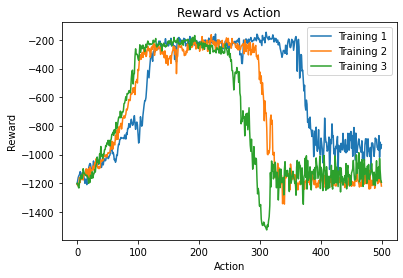

In [12]:
# collect saved results
import numpy as np
r1 = np.genfromtxt("InvertedPendulum_results.csv", delimiter=",")
all_results = [r1]
labels = ["REINFORCE"]

##############################################################
# Plot your Policy Gradient results below
##############################################################
import matplotlib.pyplot as plt         # Import Plotting tools

plt.plot(list(range(len(all_results[0][0][:]))), all_results[0][0][:], label='Training 1')       # First Plot
plt.plot(list(range(len(all_results[0][1][:]))), all_results[0][1][:], label='Training 2')       # Second PLot
plt.plot(list(range(len(all_results[0][2][:]))), all_results[0][2][:], label='Training 3')       # Third Plot
plt.title('Reward vs Action')              # Title
plt.xlabel('Action')                       # X-Axis
plt.ylabel('Reward')                       # Y-Axis
plt.legend()                               # Legend
plt.show()                                 # Plot

In [ ]:
# Observing the policy running

import gym
env = gym.make("Pendulum-v0")
alg = REINFORCE(env,stochastic=True)
res = alg.train(learning_rate=0.005,gamma=0.95,num_iterations=175,steps_per_iteration=15000)

for episode in range(1):
    observation = env.reset()
    for x in range(10000):
        env.render()
        #action = env.action_space.sample()                               # Random action
        action = alg.compute_action(observation.reshape(1,3))             # Action under policy
        observation, reward, done, info =env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Iteration 0 return: -1205.2586225480834
Iteration 1 return: -1165.1893684633696
Iteration 2 return: -1235.411227014965
Iteration 3 return: -1179.7742214066877
Iteration 4 return: -1192.0434712782317
Iteration 5 return: -1167.156426590712
Iteration 6 return: -1270.4418737484432
Iteration 7 return: -1194.1955126793148
Iteration 8 return: -1218.445826322011
Iteration 9 return: -1172.8682029311917
Iteration 10 return: -1136.027020815229
Iteration 11 return: -1126.8608401431827
Iteration 12 return: -1220.9887417425991
Iteration 13 return: -1157.9611845394968
Iteration 14 return: -1108.3049907046216
Iteration 15 return: -1162.3630075532446
Iteration 16 return: -1159.576023759679
Iteration 17 return: -1121.9792367154826
Iteration 18 return: -1145.297442568449
Iteration 19 return: -1135.6858511762073
Iteration 20 return: -1100.1382809566512
Iteration 21 return: -1160.6869681074704
Iteration 22 return: -1126.1751730291296
Iteration 23 return: -1092.7708763895835
Iteration 24 return: -1106.47504